In [1]:
import gzip
import pandas as pd
import os
from collections import defaultdict
from scipy.stats import fisher_exact
import ast
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = os.getcwd()

# Print path
print(path)

C:\Users\fried\Desktop\Project_emerson


#### 1. Read all the patient files and make a dictionary where key = combination, value = list of reperoire_ids

In [46]:
# Path of file
files_path = path + '\\data\\HLA_emerson_2017'

all_files = os.listdir(files_path)

tsv_gz_files = [f for f in all_files if f.endswith('.tsv.gz')]

tsv_gz_files = tsv_gz_files[:400]

patient_names = [f.split('.')[0] for f in tsv_gz_files]
# print(patient_names)

In [3]:
#read patient file
dataframes = []

clonotype_occurences = defaultdict(set)

for f in tsv_gz_files:
    file_path = os.path.join(files_path, f)
    with gzip.open(file_path, 'rt') as fi:
        # Inlezen als pandas DataFrame
        df = pd.read_csv(fi, sep='\t')
        
        for row in df.itertuples(index=False):
            combination = (row.v_call, row.junction_aa, row.j_call)
            rep_id = row.repertoire_id
            clonotype_occurences[combination].add(rep_id)
            
        


In [4]:
print(len(clonotype_occurences))

44768327


In [5]:
tcr_df = pd.DataFrame(list(clonotype_occurences.items()), columns=['combination', 'repertoire_ids'])

In [6]:
tcr_df = tcr_df[tcr_df['repertoire_ids'].apply(len) >= 5]
tcr_df.reset_index(drop=True, inplace=True)
tcr_df

,combination,repertoire_ids
0,"(TRBV5-1, CASSLRGSGNTIYF, TRBJ1-3)","{P00103_clonotypes, P00241_clonotypes, P00356_..."
1,"(TRBV4-2, CASSQEGQSSYEQYF, TRBJ2-7)","{P00001_clonotypes, P00017_clonotypes, P00008_..."
2,"(TRBV6-5, CASSYSGSNQPQHF, TRBJ1-5)","{P00247_clonotypes, P00113_clonotypes, P00356_..."
3,"(TRBV6-5, CASSYYGTAQETQYF, TRBJ2-5)","{P00001_clonotypes, P00126_clonotypes, P00003_..."
4,"(TRBV6-4, CASSDNSGANVLTF, TRBJ2-6)","{P00054_clonotypes, P00325_clonotypes, P00331_..."
...,...,...
1007240,"(TRBV5-1, CASSLSGQNEKLFF, TRBJ1-4)","{P00384_clonotypes, P00351_clonotypes, P00357_..."
1007241,"(TRBV7-6, CASSLAGPSSGNTIYF, TRBJ1-3)","{P00384_clonotypes, P00385_clonotypes, P00352_..."
1007242,"(TRBV12-5, CASGHQETQYF, TRBJ2-5)","{P00368_clonotypes, P00367_clonotypes, P00353_..."
1007243,"(TRBV18, CASSPTGIYNEQFF, TRBJ2-1)","{P00397_clonotypes, P00368_clonotypes, P00373_..."


In [7]:
# # Wegschrijven naar een TSV-bestand
tcr_df.to_csv('results\\tcr_df_output.tsv', sep='\t', index=False)  # sep='\t' voor TSV


In [41]:
# Inlezen van het TSV-bestand
tcr_df = pd.read_csv(path + "\\results\\tcr_df_output.tsv", sep='\t')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)


#### 2. Filter HLA_emerson_2017.tsv such that it has less columns and can be easier filtered for HLA-A*02:01 and CMV positive/negative

In [4]:
patient_allel_path = path + "\\data\\HLA_emerson_2017.tsv"

# Lees het TSV-bestand in als DataFrame
patient_df = pd.read_csv(patient_allel_path, sep='\t')

# Bekijk de eerste paar rijen om te controleren of het correct is ingelezen
patient_df.head()

,inferred_format,n_sequences,n_nan,n_non_productive_vj,n_invalid_junction_aa,n_duplicates_merged,n_clonotypes_after_filtering,n_TRB,patient_id,repertoire_id,metadata_tags,HLA-A,HLA-B,HLA-C,HLA-DQA1,HLA-DQB1,HLA-DRB1,HLA-DPB1
0,emerson,198515.0,66497.0,2113.0,2763.0,2496.0,124646.0,124646.0,P00087_clonotypes,P00087_clonotypes,"['46 Years', 'Male', 'Unknown Ethnicity', 'Unk...",[],[],[],[],[],[],[]
1,emerson,127886.0,46216.0,1505.0,2087.0,1335.0,76743.0,76743.0,P00011_clonotypes,P00011_clonotypes,"['32 Years', 'Female', 'Unknown Ethnicity', 'U...",['HLA-A*29:02'],"['HLA-B*58:01', 'HLA-B*44:03']","['HLA-C*16:01', 'HLA-C*07:01']","['HLA-DQA1*04:01', 'HLA-DQA1*02:01']","['HLA-DQB1*04:02', 'HLA-DQB1*02:02']","['HLA-DRB1*08:04', 'HLA-DRB1*07:01']","['HLA-DPB1*01:01', 'HLA-DPB1*104:01']"
2,emerson,166088.0,51792.0,1051.0,2128.0,3028.0,108089.0,108089.0,P00132_clonotypes,P00132_clonotypes,"['55 Years', 'Male', 'Non-Hispanic or Latino',...","['HLA-A*01:01', 'HLA-A*24:02']","['HLA-B*18:01', 'HLA-B*37:01']","['HLA-C*12:03', 'HLA-C*06:02']","['HLA-DQA1*01:05', 'HLA-DQA1*05:05']","['HLA-DQB1*03:01', 'HLA-DQB1*05:01']","['HLA-DRB1*11:04', 'HLA-DRB1*10:01']","['HLA-DPB1*04:01', 'HLA-DPB1*02:01']"
3,emerson,253878.0,92201.0,2528.0,3241.0,2651.0,153257.0,153257.0,P00116_clonotypes,P00116_clonotypes,"['38 Years', 'Female', 'Unknown Ethnicity', 'U...","['HLA-A*01:01', 'HLA-A*29:02']","['HLA-B*51:01', 'HLA-B*08:01']","['HLA-C*14:02', 'HLA-C*07:01']","['HLA-DQA1*01:02', 'HLA-DQA1*03:03']","['HLA-DQB1*06:02', 'HLA-DQB1*03:01']","['HLA-DRB1*04:07', 'HLA-DRB1*15:01']","['HLA-DPB1*04:01', 'HLA-DPB1*03:01']"
4,emerson,168951.0,52843.0,844.0,5300.0,4549.0,105415.0,105415.0,P00063_clonotypes,P00063_clonotypes,"['37 Years', 'Female', 'Unknown Ethnicity', 'U...","['HLA-A*29:02', 'HLA-A*30:01']","['HLA-B*45:01', 'HLA-B*13:02']",['HLA-C*06:02'],"['HLA-DQA1*03:03', 'HLA-DQA1*02:01']","['HLA-DQB1*03:01', 'HLA-DQB1*02:02']","['HLA-DRB1*04:01', 'HLA-DRB1*07:01']","['HLA-DPB1*04:02', 'HLA-DPB1*04:01']"


In [5]:
# Definieer de kolommen die gecontroleerd moeten worden op lege lijsten
hla_columns = ['HLA-A']#, 'HLA-B', 'HLA-C', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1', 'HLA-DPB1']

# Filter de DataFrame om alleen rijen te behouden waar niet alle HLA-kolommen '[]' bevatten
patient_df_filtered= patient_df[~patient_df[hla_columns].apply(lambda row: all(val == '[]' for val in row), axis=1)]

# Reset de indexen
patient_df_filtered.reset_index(drop=True, inplace=True)

patient_df_filtered = patient_df_filtered[['repertoire_id', 'HLA-A']]

print(len(patient_df_filtered))
patient_df_filtered.head(10)

625


,repertoire_id,HLA-A
0,P00011_clonotypes,['HLA-A*29:02']
1,P00132_clonotypes,"['HLA-A*01:01', 'HLA-A*24:02']"
2,P00116_clonotypes,"['HLA-A*01:01', 'HLA-A*29:02']"
3,P00063_clonotypes,"['HLA-A*29:02', 'HLA-A*30:01']"
4,P00138_clonotypes,"['HLA-A*32:01', 'HLA-A*02:01']"
5,P00117_clonotypes,['HLA-A*02:01']
6,P00072_clonotypes,"['HLA-A*31:01', 'HLA-A*02:01']"
7,P00120_clonotypes,"['HLA-A*03:01', 'HLA-A*02:01']"
8,P00181_clonotypes,['HLA-A*03:01']
9,P00052_clonotypes,['HLA-A*02:01']


In [8]:
# Filter de rijen in patient_df_filtered waarvan repertoire_id in patient_names zit
patient_df_filtered = patient_df_filtered[patient_df_filtered['repertoire_id'].isin(patient_names)]
patient_df_filtered = patient_df_filtered.reset_index(drop=True)

# Bekijk het resultaat
print(len(patient_df_filtered))


370


In [9]:
patient_df_filtered['has_HLA_A02_01'] = patient_df_filtered['HLA-A'].apply(lambda x: 'HLA-A*02:01' in x if isinstance(x, str) else False)

In [10]:
patient_df_filtered.head(10)

,repertoire_id,HLA-A,has_HLA_A02_01
0,P00011_clonotypes,['HLA-A*29:02'],False
1,P00132_clonotypes,"['HLA-A*01:01', 'HLA-A*24:02']",False
2,P00116_clonotypes,"['HLA-A*01:01', 'HLA-A*29:02']",False
3,P00063_clonotypes,"['HLA-A*29:02', 'HLA-A*30:01']",False
4,P00138_clonotypes,"['HLA-A*32:01', 'HLA-A*02:01']",True
5,P00117_clonotypes,['HLA-A*02:01'],True
6,P00072_clonotypes,"['HLA-A*31:01', 'HLA-A*02:01']",True
7,P00120_clonotypes,"['HLA-A*03:01', 'HLA-A*02:01']",True
8,P00181_clonotypes,['HLA-A*03:01'],False
9,P00052_clonotypes,['HLA-A*02:01'],True


In [11]:
len(patient_df_filtered)

370

#### 3. Fisher_exact test for HLA A02:01

#### Make a dataframe where every row contains the TCR (combination), the p-value and odds ratio of fisher_exact method

##### Use a pseudocount of 0.1

In [14]:
# Lijst voor het opslaan van de resultaten
fisher_exact_results = []
for index, row in tcr_df.iterrows():
    # Haal de eerste rij van tcr_df en zijn combinatie en repertoire_ids
    repertoire_ids = row['repertoire_ids']  # Aangenomen dat repertoire_ids een lijst is
    combination = row['combination']


    # Filter patient_df_filtered op basis van de repertoire_ids
    filtered_patients = patient_df_filtered[patient_df_filtered['repertoire_id'].isin(repertoire_ids)]


    # Tel het aantal patiënten in elke categorie
    have_hla_and_tcr = len(filtered_patients[filtered_patients['has_HLA_A02_01'] == True]) + 0.1  # Aantal met HLA en TCR
    have_no_hla_and_tcr = len(filtered_patients[filtered_patients['has_HLA_A02_01'] == False]) + 0.1  # Aantal zonder HLA maar met TCR


    # Aantal patiënten zonder TCR
    have_hla_no_tcr = len(patient_df_filtered[(patient_df_filtered['has_HLA_A02_01'] == True) & 
                                               (~patient_df_filtered['repertoire_id'].isin(repertoire_ids))]) + 0.1
    have_no_hla_no_tcr = len(patient_df_filtered[(patient_df_filtered['has_HLA_A02_01'] == False) & 
                                                  (~patient_df_filtered['repertoire_id'].isin(repertoire_ids))]) + 0.1

    # Maak de 2x2-contingentietabel
    contingency_table = [
        [
            have_hla_and_tcr,  # a: patiënten met zowel HLA als TCR
            have_no_hla_and_tcr  # b: patiënten zonder HLA maar met TCR
        ],
        [
            have_hla_no_tcr,  # c: patiënten met HLA maar zonder TCR
            have_no_hla_no_tcr  # d: patiënten zonder HLA en zonder TCR
        ]
    ]

    # Voer de Fisher's Exact Test uit
    odds_ratio, p_value = fisher_exact(contingency_table)

    # Voeg de resultaten toe aan de lijst
    fisher_exact_results.append({
        'HLA': 'HLA-A*02:01',
        'TCR': combination,
        'odds_ratio': odds_ratio,
        'p_value': p_value,
        'have_hla_and_tcr' : have_hla_and_tcr,
        'have_no_hla_and_tcr': have_no_hla_and_tcr,
        'have_hla_no_tcr': have_hla_no_tcr,
        'have_no_hla_no_tcr': have_no_hla_no_tcr
    })

# Zet de resultaten om in een DataFrame
fisher_exact_results_df = pd.DataFrame(fisher_exact_results)


In [15]:
fisher_exact_results_df

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr
0,HLA-A*02:01,"('TRBV5-1', 'CASSLRGSGNTIYF', 'TRBJ1-3')",0.664139,0.254440,15.1,28.1,146.1,181.1
1,HLA-A*02:01,"('TRBV4-2', 'CASSQEGQSSYEQYF', 'TRBJ2-7')",0.805288,0.782505,5.1,8.1,156.1,201.1
2,HLA-A*02:01,"('TRBV6-5', 'CASSYSGSNQPQHF', 'TRBJ1-5')",0.917553,0.751462,69.1,94.1,92.1,115.1
3,HLA-A*02:01,"('TRBV6-5', 'CASSYYGTAQETQYF', 'TRBJ2-5')",1.303797,1.000000,3.1,3.1,158.1,206.1
4,HLA-A*02:01,"('TRBV6-4', 'CASSDNSGANVLTF', 'TRBJ2-6')",1.184896,0.451108,65.1,76.1,96.1,133.1
...,...,...,...,...,...,...,...,...
1007240,HLA-A*02:01,"('TRBV5-1', 'CASSLSGQNEKLFF', 'TRBJ1-4')",1.301887,1.000000,2.1,2.1,159.1,207.1
1007241,HLA-A*02:01,"('TRBV7-6', 'CASSLAGPSSGNTIYF', 'TRBJ1-3')",0.863732,1.000000,2.1,3.1,159.1,206.1
1007242,HLA-A*02:01,"('TRBV12-5', 'CASGHQETQYF', 'TRBJ2-5')",0.429167,0.635611,1.1,3.1,160.1,206.1
1007243,HLA-A*02:01,"('TRBV18', 'CASSPTGIYNEQFF', 'TRBJ2-1')",1.301887,1.000000,2.1,2.1,159.1,207.1


In [16]:
# Neem de -log10 van de p-value en de log2 van de odds_ratio en voeg ze toe aan de DataFrame
fisher_exact_results_df['log2_odds_ratio'] = np.log2(fisher_exact_results_df['odds_ratio'])
fisher_exact_results_df['neg_log10_p_value'] = -np.log10(fisher_exact_results_df['p_value'])

# Bekijk de bijgewerkte DataFrame
fisher_exact_results_df

C:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value
0,HLA-A*02:01,"('TRBV5-1', 'CASSLRGSGNTIYF', 'TRBJ1-3')",0.664139,0.254440,15.1,28.1,146.1,181.1,-0.590443,0.594414
1,HLA-A*02:01,"('TRBV4-2', 'CASSQEGQSSYEQYF', 'TRBJ2-7')",0.805288,0.782505,5.1,8.1,156.1,201.1,-0.312422,0.106513
2,HLA-A*02:01,"('TRBV6-5', 'CASSYSGSNQPQHF', 'TRBJ1-5')",0.917553,0.751462,69.1,94.1,92.1,115.1,-0.124136,0.124093
3,HLA-A*02:01,"('TRBV6-5', 'CASSYYGTAQETQYF', 'TRBJ2-5')",1.303797,1.000000,3.1,3.1,158.1,206.1,0.382720,-0.000000
4,HLA-A*02:01,"('TRBV6-4', 'CASSDNSGANVLTF', 'TRBJ2-6')",1.184896,0.451108,65.1,76.1,96.1,133.1,0.244760,0.345719
...,...,...,...,...,...,...,...,...,...,...
1007240,HLA-A*02:01,"('TRBV5-1', 'CASSLSGQNEKLFF', 'TRBJ1-4')",1.301887,1.000000,2.1,2.1,159.1,207.1,0.380604,-0.000000
1007241,HLA-A*02:01,"('TRBV7-6', 'CASSLAGPSSGNTIYF', 'TRBJ1-3')",0.863732,1.000000,2.1,3.1,159.1,206.1,-0.211345,-0.000000
1007242,HLA-A*02:01,"('TRBV12-5', 'CASGHQETQYF', 'TRBJ2-5')",0.429167,0.635611,1.1,3.1,160.1,206.1,-1.220390,0.196808
1007243,HLA-A*02:01,"('TRBV18', 'CASSPTGIYNEQFF', 'TRBJ2-1')",1.301887,1.000000,2.1,2.1,159.1,207.1,0.380604,-0.000000


In [17]:
# Voeg een kolom toe om te controleren of de p-value kleiner is dan 0.05
fisher_exact_results_df['significant'] = fisher_exact_results_df['p_value'] < 0.05


In [51]:
# Wegschrijven naar een TSV-bestand
fisher_exact_results_df.to_csv('results\\fisher_exact_results.tsv', sep='\t', index=False)  # sep='\t' voor TSV

In [53]:
# Inlezen van het TSV-bestand
fisher_exact_results_df = pd.read_csv(path + "\\results\\fisher_exact_results.tsv", sep='\t')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)

In [54]:
## Bij fisher exact test: in tabel bij 'have_hla_and_tcr' en 'have_no_hla_and_tcr' een pseudocount (=0.1) optellen

In [55]:
fisher_exact_results_df.sort_values(by=["p_value"]).head(10)
#fisher_exact_results_df.sort_values(by=["log2_odds_ratio"], ascending=False).head(10)

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant
49502,HLA-A*02:01,"(TRBV5-1, CASSLSSGNTIYF, TRBJ1-3)",0.199949,0.000001,10.1,52.1,151.1,157.1,-2.322296,5.970824,True
390346,HLA-A*02:01,"(TRBV7-9, CASSLRQGPYEQYF, TRBJ2-7)",0.000000,0.000015,0.1,19.1,161.1,190.1,-inf,4.812391,True
570561,HLA-A*02:01,"(TRBV6-5, CASSYSWGTYEQYF, TRBJ2-7)",21.369863,0.000025,15.1,1.1,146.1,208.1,4.417506,4.595296,True
523518,HLA-A*02:01,"(TRBV7-2, CASSLLAGPYEQYF, TRBJ2-7)",0.000000,0.000029,0.1,18.1,161.1,191.1,-inf,4.531973,True
406110,HLA-A*02:01,"(TRBV28, CASSFAGYGYTF, TRBJ1-2)",0.053125,0.000036,1.1,22.1,160.1,187.1,-4.234465,4.449429,True
15448,HLA-A*02:01,"(TRBV18, CASSPGGDQPQHF, TRBJ1-5)",0.403846,0.000046,46.1,104.1,115.1,105.1,-1.308122,4.333028,True
450854,HLA-A*02:01,"(TRBV5-4, CASSLGGRDYGYTF, TRBJ1-2)",0.000000,0.000056,0.1,17.1,161.1,192.1,-inf,4.249813,True
528981,HLA-A*02:01,"(TRBV28, CASSFLGDTQYF, TRBJ2-3)",0.000000,0.000056,0.1,17.1,161.1,192.1,-inf,4.249813,True
582780,HLA-A*02:01,"(TRBV7-2, CASSLGSVNTEAFF, TRBJ1-1)",0.000000,0.000056,0.1,17.1,161.1,192.1,-inf,4.249813,True
262883,HLA-A*02:01,"(TRBV5-1, CASSSTGMNTEAFF, TRBJ1-1)",0.227920,0.000063,8.1,39.1,153.1,170.1,-2.133399,4.202057,True


In [56]:
query_tcr = "CASSIRSSYEQYF"

In [57]:
result = fisher_exact_results_df[fisher_exact_results_df['TCR'].apply(lambda x: query_tcr in x)]
result

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant
14109,HLA-A*02:01,"(TRBV19, CASSIRSSYEQYF, TRBJ2-7)",0.882812,0.598341,69.1,96.1,92.1,113.1,-0.179821,0.223051,False
66554,HLA-A*02:01,"(TRBV19, CASSIRSSYEQYF, TRBJ2-5)",0.861290,0.653701,21.1,31.1,140.1,178.1,-0.215428,0.184621,False


#### Volcanoplot y-as (-log 10 van p-value), x-as (log2 van odds ratio)


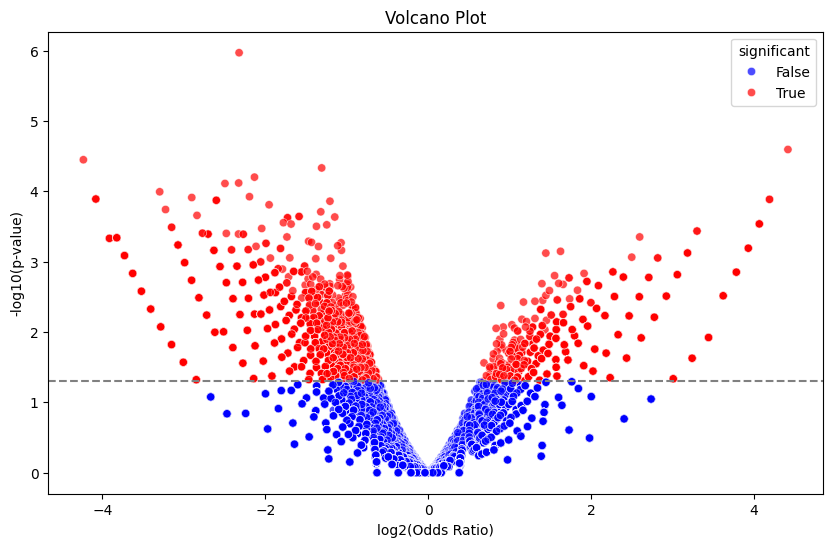

In [25]:
# Creëer een figuur en een as
plt.figure(figsize=(10, 6))

# Maak de volcano plot
sns.scatterplot(data=fisher_exact_results_df, 
                 x='log2_odds_ratio', 
                 y='neg_log10_p_value', 
                 hue='significant',  # Gebruik de nieuwe kolom voor kleuren
                 palette={True: 'red', False: 'blue'},  # Rood voor significant, blauw voor niet-significant
                 alpha=0.7)

# Voeg een horizontale lijn toe voor de drempel (bijv. p < 0.05)
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

# Labels en titel
plt.title('Volcano Plot')
plt.xlabel('log2(Odds Ratio)')
plt.ylabel('-log10(p-value)')

# Toon de plot
plt.show()



In [21]:
# # Filter de DataFrame om alleen rijen met p-value < 0.05 te behouden
# significant_results = fisher_exact_results_df[fisher_exact_results_df['p_value'] < 0.05]

# # Bekijk de gefilterde resultaten
# significant_results

In [ ]:
#lijst met tcr's van trainingset gebruiken om te zien hoe vaak die voorkomt in validatiedataset (resterende 266 patienten), 
#in welke personen ze voorkomen en plot maken van emerson paper (percentage)


# maak een simpele classifier, zoals logistische regressie, eenvoudigste machine learning model is een treshold
# features: aantal 

#### Check for significant TCR in given list 

In [26]:
#load given list of significant tcr's
significant_tcr_df = pd.read_csv(path + "//significant_tcrs.tsv", sep='\t')
significant_tcr_df

,Row,TCR+V,p_BH,TCR_sharing,HLA $\cap$ TCRs,HLA,chain,Attribute,v_call,junction_aa
0,2868,CASSIRSSYEQYF+TRBV19,5.828883e-93,322.0,286.0,A*02:01,beta,Overrepresented,CASSIRSSYEQYF,TRBV19
1,2869,CSVGTGGTNEKLFF+TRBV29,1.738559e-84,250.0,236.0,A*02:01,beta,Overrepresented,CSVGTGGTNEKLFF,TRBV29
2,2870,CASSIRSAYEQYF+TRBV19,7.512673e-50,166.0,157.0,A*02:01,beta,Overrepresented,CASSIRSAYEQYF,TRBV19
3,2871,CSARDGTGNGYTF+TRBV20,7.504383e-47,138.0,135.0,A*02:01,beta,Overrepresented,CSARDGTGNGYTF,TRBV20
4,2872,CSARDRTGNGYTF+TRBV20,8.746265e-45,148.0,141.0,A*02:01,beta,Overrepresented,CSARDRTGNGYTF,TRBV20
5,2874,CASSEDGMNTEAFF+TRBV10,2.097653e-38,120.0,117.0,A*02:01,beta,Overrepresented,CASSEDGMNTEAFF,TRBV10
6,2876,CSVGSGGTNEKLFF+TRBV29,5.579374e-35,111.0,108.0,A*02:01,beta,Overrepresented,CSVGSGGTNEKLFF,TRBV29
7,2877,CASSVRSSYEQYF+TRBV19,6.370092e-35,108.0,106.0,A*02:01,beta,Overrepresented,CASSVRSSYEQYF,TRBV19
8,2879,CASSQSPGGTQYF+TRBV14,1.754853e-34,107.0,105.0,A*02:01,beta,Overrepresented,CASSQSPGGTQYF,TRBV14
9,2880,CASSLEGQASSYEQYF+TRBV5,4.462534e-34,113.0,109.0,A*02:01,beta,Overrepresented,CASSLEGQASSYEQYF,TRBV5


In [27]:
columns_to_keep = ['TCR+V', 'HLA', 'v_call', 'junction_aa', 'Attribute']
significant_tcr_df = significant_tcr_df[columns_to_keep]
significant_tcr_df = significant_tcr_df.rename(columns={'v_call': 'junction_aa', 'junction_aa': 'v_call'})
significant_tcr_df

,TCR+V,HLA,junction_aa,v_call,Attribute
0,CASSIRSSYEQYF+TRBV19,A*02:01,CASSIRSSYEQYF,TRBV19,Overrepresented
1,CSVGTGGTNEKLFF+TRBV29,A*02:01,CSVGTGGTNEKLFF,TRBV29,Overrepresented
2,CASSIRSAYEQYF+TRBV19,A*02:01,CASSIRSAYEQYF,TRBV19,Overrepresented
3,CSARDGTGNGYTF+TRBV20,A*02:01,CSARDGTGNGYTF,TRBV20,Overrepresented
4,CSARDRTGNGYTF+TRBV20,A*02:01,CSARDRTGNGYTF,TRBV20,Overrepresented
5,CASSEDGMNTEAFF+TRBV10,A*02:01,CASSEDGMNTEAFF,TRBV10,Overrepresented
6,CSVGSGGTNEKLFF+TRBV29,A*02:01,CSVGSGGTNEKLFF,TRBV29,Overrepresented
7,CASSVRSSYEQYF+TRBV19,A*02:01,CASSVRSSYEQYF,TRBV19,Overrepresented
8,CASSQSPGGTQYF+TRBV14,A*02:01,CASSQSPGGTQYF,TRBV14,Overrepresented
9,CASSLEGQASSYEQYF+TRBV5,A*02:01,CASSLEGQASSYEQYF,TRBV5,Overrepresented


In [58]:
fisher_columns = ['TCR', 'odds_ratio', 'p_value']
fisher_exact_results_df_copy = fisher_exact_results_df[fisher_columns]
fisher_exact_results_df_copy

,TCR,odds_ratio,p_value
0,"(TRBV5-1, CASSLRGSGNTIYF, TRBJ1-3)",0.664139,0.254440
1,"(TRBV4-2, CASSQEGQSSYEQYF, TRBJ2-7)",0.805288,0.782505
2,"(TRBV6-5, CASSYSGSNQPQHF, TRBJ1-5)",0.917553,0.751462
3,"(TRBV6-5, CASSYYGTAQETQYF, TRBJ2-5)",1.303797,1.000000
4,"(TRBV6-4, CASSDNSGANVLTF, TRBJ2-6)",1.184896,0.451108
...,...,...,...
1007240,"(TRBV5-1, CASSLSGQNEKLFF, TRBJ1-4)",1.301887,1.000000
1007241,"(TRBV7-6, CASSLAGPSSGNTIYF, TRBJ1-3)",0.863732,1.000000
1007242,"(TRBV12-5, CASGHQETQYF, TRBJ2-5)",0.429167,0.635611
1007243,"(TRBV18, CASSPTGIYNEQFF, TRBJ2-1)",1.301887,1.000000


In [59]:
fisher_exact_results_df_copy[['v_call', 'junction_aa', 'j_call']] = pd.DataFrame(
    fisher_exact_results_df_copy['TCR'].tolist(), index=fisher_exact_results_df_copy.index
)

# Maak de 'TCR+V'-kolom door 'v_call' en 'junction_aa' te combineren
fisher_exact_results_df_copy['TCR+V'] = fisher_exact_results_df_copy['junction_aa'] + "+" + fisher_exact_results_df_copy['v_call']  

C:\Users\fried\AppData\Local\Temp\ipykernel_20792\2169312115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fisher_exact_results_df_copy[['v_call', 'junction_aa', 'j_call']] = pd.DataFrame(
C:\Users\fried\AppData\Local\Temp\ipykernel_20792\2169312115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fisher_exact_results_df_copy[['v_call', 'junction_aa', 'j_call']] = pd.DataFrame(
C:\Users\fried\AppData\Local\Temp\ipykernel_20792\2169312115.py:1: SettingWithCopyWarning: 
A value is trying to be set on

In [60]:
fisher_exact_results_df_copy['v_call'] = fisher_exact_results_df_copy['v_call'].str.split('-').str[0]
fisher_exact_results_df_copy

C:\Users\fried\AppData\Local\Temp\ipykernel_20792\2956598323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fisher_exact_results_df_copy['v_call'] = fisher_exact_results_df_copy['v_call'].str.split('-').str[0]


,TCR,odds_ratio,p_value,v_call,junction_aa,j_call,TCR+V
0,"(TRBV5-1, CASSLRGSGNTIYF, TRBJ1-3)",0.664139,0.254440,TRBV5,CASSLRGSGNTIYF,TRBJ1-3,CASSLRGSGNTIYF+TRBV5-1
1,"(TRBV4-2, CASSQEGQSSYEQYF, TRBJ2-7)",0.805288,0.782505,TRBV4,CASSQEGQSSYEQYF,TRBJ2-7,CASSQEGQSSYEQYF+TRBV4-2
2,"(TRBV6-5, CASSYSGSNQPQHF, TRBJ1-5)",0.917553,0.751462,TRBV6,CASSYSGSNQPQHF,TRBJ1-5,CASSYSGSNQPQHF+TRBV6-5
3,"(TRBV6-5, CASSYYGTAQETQYF, TRBJ2-5)",1.303797,1.000000,TRBV6,CASSYYGTAQETQYF,TRBJ2-5,CASSYYGTAQETQYF+TRBV6-5
4,"(TRBV6-4, CASSDNSGANVLTF, TRBJ2-6)",1.184896,0.451108,TRBV6,CASSDNSGANVLTF,TRBJ2-6,CASSDNSGANVLTF+TRBV6-4
...,...,...,...,...,...,...,...
1007240,"(TRBV5-1, CASSLSGQNEKLFF, TRBJ1-4)",1.301887,1.000000,TRBV5,CASSLSGQNEKLFF,TRBJ1-4,CASSLSGQNEKLFF+TRBV5-1
1007241,"(TRBV7-6, CASSLAGPSSGNTIYF, TRBJ1-3)",0.863732,1.000000,TRBV7,CASSLAGPSSGNTIYF,TRBJ1-3,CASSLAGPSSGNTIYF+TRBV7-6
1007242,"(TRBV12-5, CASGHQETQYF, TRBJ2-5)",0.429167,0.635611,TRBV12,CASGHQETQYF,TRBJ2-5,CASGHQETQYF+TRBV12-5
1007243,"(TRBV18, CASSPTGIYNEQFF, TRBJ2-1)",1.301887,1.000000,TRBV18,CASSPTGIYNEQFF,TRBJ2-1,CASSPTGIYNEQFF+TRBV18


In [63]:
# Merge de twee DataFrames op basis van de kolom 'TCR+V'
merged_df = pd.merge(fisher_exact_results_df_copy, significant_tcr_df, on='TCR+V', how='inner')
merged_df.sort_values(by=["p_value"])

,TCR,odds_ratio,p_value,v_call_x,junction_aa_x,j_call,TCR+V,HLA,junction_aa_y,v_call_y,Attribute
20,"(TRBV9, CASSVGGGDYGYTF, TRBJ1-2)",0.618714,0.048294,TRBV9,CASSVGGGDYGYTF,TRBJ1-2,CASSVGGGDYGYTF+TRBV9,A*02:01,CASSVGGGDYGYTF,TRBV9,Overrepresented
23,"(TRBV19, CASSTRSSYEQYF, TRBJ2-7)",0.596659,0.054106,TRBV19,CASSTRSSYEQYF,TRBJ2-7,CASSTRSSYEQYF+TRBV19,A*02:01,CASSTRSSYEQYF,TRBV19,Overrepresented
15,"(TRBV19, CASSGRSTGELFF, TRBJ2-2)",0.386619,0.071223,TRBV19,CASSGRSTGELFF,TRBJ2-2,CASSGRSTGELFF+TRBV19,A*02:01,CASSGRSTGELFF,TRBV19,Overrepresented
8,"(TRBV19, CASSIRSTGELFF, TRBJ2-2)",1.603544,0.117255,TRBV19,CASSIRSTGELFF,TRBJ2-2,CASSIRSTGELFF+TRBV19,A*02:01,CASSIRSTGELFF,TRBV19,Overrepresented
27,"(TRBV14, CASSQSPGGIQYF, TRBJ2-4)",0.593043,0.204891,TRBV14,CASSQSPGGIQYF,TRBJ2-4,CASSQSPGGIQYF+TRBV14,A*02:01,CASSQSPGGIQYF,TRBV14,Overrepresented
25,"(TRBV19, CASSSRSAYEQYF, TRBJ2-7)",0.548295,0.277328,TRBV19,CASSSRSAYEQYF,TRBJ2-7,CASSSRSAYEQYF+TRBV19,A*02:01,CASSSRSAYEQYF,TRBV19,Overrepresented
12,"(TRBV9, CASSVGGGTYEQYF, TRBJ2-7)",0.811866,0.345347,TRBV9,CASSVGGGTYEQYF,TRBJ2-7,CASSVGGGTYEQYF+TRBV9,A*02:01,CASSVGGGTYEQYF,TRBV9,Overrepresented
4,"(TRBV19, CASSTRSAYEQYF, TRBJ2-7)",1.419797,0.382497,TRBV19,CASSTRSAYEQYF,TRBJ2-7,CASSTRSAYEQYF+TRBV19,A*02:01,CASSTRSAYEQYF,TRBV19,Overrepresented
13,"(TRBV9, CASSVGGGTYEQYF, TRBJ2-5)",1.449664,0.394919,TRBV9,CASSVGGGTYEQYF,TRBJ2-5,CASSVGGGTYEQYF+TRBV9,A*02:01,CASSVGGGTYEQYF,TRBV9,Overrepresented
10,"(TRBV19, CASSIRSAYEQYF, TRBJ2-7)",0.804317,0.403347,TRBV19,CASSIRSAYEQYF,TRBJ2-7,CASSIRSAYEQYF+TRBV19,A*02:01,CASSIRSAYEQYF,TRBV19,Overrepresented


#### Use the validation patients (266 patients) and match/count the HLA-02.01 related TCR's for every patient

##### make a table with 3 columns: patient, #total TCR's and #HLA-02.01 related TCR's (from the fisher_exact_results_df where p-value < 0.05)

In [116]:
related_tcrs = fisher_exact_results_df[fisher_exact_results_df['p_value'] < 0.05].reset_index(drop=True)
related_tcrs

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant
0,HLA-A*02:01,"(TRBV5-1, CASSWDKSYEQYF, TRBJ2-7)",3.758333,0.030059,11.1,4.1,150.1,205.1,1.910093,1.522026,True
1,HLA-A*02:01,"(TRBV6-1, CASSGQENTEAFF, TRBJ1-1)",0.406926,0.047270,7.1,21.1,154.1,188.1,-1.297160,1.325413,True
2,HLA-A*02:01,"(TRBV6-1, CASSGDRDNQPQHF, TRBJ1-5)",8.051613,0.046153,6.1,1.1,155.1,208.1,3.009278,1.335804,True
3,HLA-A*02:01,"(TRBV6-5, CASSYSPGGDTEAFF, TRBJ1-1)",2.138571,0.043645,20.1,13.1,141.1,196.1,1.096647,1.360061,True
4,HLA-A*02:01,"(TRBV6-5, CASSYSNTGELFF, TRBJ2-2)",0.578512,0.023576,40.1,76.1,121.1,133.1,-0.789580,1.627535,True
...,...,...,...,...,...,...,...,...,...,...,...
33009,HLA-A*02:01,"(TRBV6-5, CASSYAKNYGYTF, TRBJ1-2)",inf,0.015055,5.1,0.1,156.1,209.1,inf,1.822323,True
33010,HLA-A*02:01,"(TRBV7-9, CASSFAGGSTDTQYF, TRBJ2-3)",0.000000,0.037906,0.1,6.1,161.1,203.1,-inf,1.421295,True
33011,HLA-A*02:01,"(TRBV11-1, CASSSGTGFYEQYF, TRBJ2-7)",inf,0.015055,5.1,0.1,156.1,209.1,inf,1.822323,True
33012,HLA-A*02:01,"(TRBV5-1, CASSLVPGSYQPQHF, TRBJ1-5)",inf,0.035096,4.1,0.1,157.1,209.1,inf,1.454742,True


In [144]:
files_path = path + '\\data\\HLA_emerson_2017'

all_files = os.listdir(files_path)

tsv_gz_files_validation = [f for f in all_files if f.endswith('.tsv.gz')]

tsv_gz_files_validation = tsv_gz_files_validation[400:]

patient_names_validation = [f.split('.')[0] for f in tsv_gz_files_validation]

In [145]:
# patient_names_validation[0]

In [146]:
validation_df = pd.DataFrame(columns=['repertoire_id', 'total_tcrs', 'related_tcrs'])
validation_data = []

In [147]:
for f in tsv_gz_files_validation:
    file_path = os.path.join(files_path, f)
    with gzip.open(file_path, 'rt') as fi:
        # Inlezen als pandas DataFrame
        df = pd.read_csv(fi, sep='\t')
        
        # Controleer of DataFrame niet leeg is
        if df.empty:
            continue
        
        # Voeg de TCR-combinaties toe als tuple
        if {'v_call', 'junction_aa', 'j_call'}.issubset(df.columns):
            df['TCR'] = [tuple(tcr) for tcr in zip(df['v_call'], df['junction_aa'], df['j_call'])]            
        else:
            continue  # Sla over als de vereiste kolommen ontbreken
        
        # Haal totalen op
        total_tcrs = len(df)
        rep_id = df['repertoire_id'].iloc[0]  # Gebruik .iloc om een fout te voorkomen
        
        # Zoek naar matches met de significante TCRs
        matching_tcrs = df[df['TCR'].isin(related_tcrs['TCR'])].shape[0]
        
        # Voeg de resultaten toe aan de lijst
        validation_data.append({
            'repertoire_id': rep_id,
            '# Total TCRs': total_tcrs,
            '# Significant TCRs': matching_tcrs
        })

# Als je de data als een DataFrame wilt hebben
validation_df = pd.DataFrame(validation_data)


In [149]:
validation_df.head()

,repertoire_id,# Total TCRs,# Significant TCRs
0,P00402_clonotypes,368856,2614
1,P00403_clonotypes,120501,825
2,P00404_clonotypes,221981,1682
3,P00405_clonotypes,41244,297
4,P00406_clonotypes,243393,1617


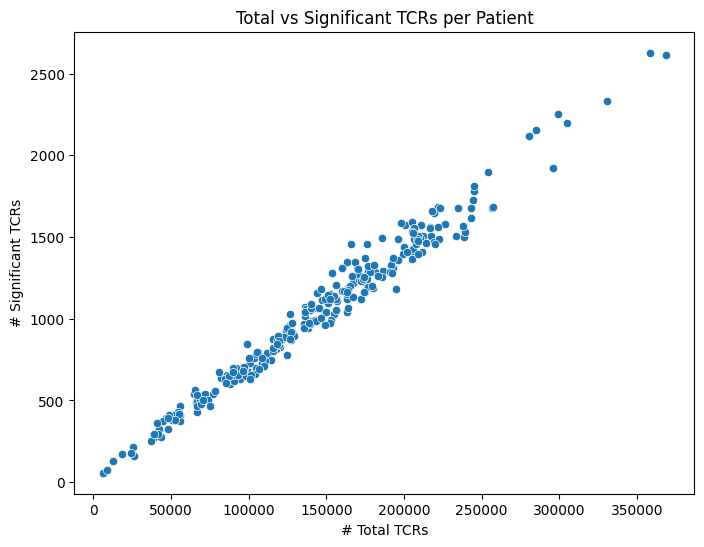

In [150]:
# Stel dat validation_df de drie kolommen bevat: 'repertoire_id', '# Total TCRs', '# Significant TCRs'
plt.figure(figsize=(8, 6))  # Stel de grootte van de plot in
sns.scatterplot(x=validation_df['# Total TCRs'], y=validation_df['# Significant TCRs'])

# Voeg labels en titel toe
plt.xlabel('# Total TCRs')
plt.ylabel('# Significant TCRs')
plt.title('Total vs Significant TCRs per Patient')

# Toon de plot
plt.show()
